In [5]:
import pandas as pd

splits = {'train': 'data/train-00000-of-00001-0e84cb2beba9ea7e.parquet', 'test': 'data/test-00000-of-00001-df4a3dda87fb136c.parquet'}
df = pd.read_parquet("hf://datasets/jbrazzy/baby_names/" + splits["train"])

/Users/luisnieblarios/projects/micrograd/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
df

,Names,Sex,Count,Year
0,Emily,F,25957,2000
1,Hannah,F,23085,2000
2,Madison,F,19968,2000
3,Ashley,F,17997,2000
4,Sarah,F,17708,2000
...,...,...,...,...
1084380,Zyheem,M,5,2019
1084381,Zykel,M,5,2019
1084382,Zyking,M,5,2019
1084383,Zyn,M,5,2019


In [8]:
df['Names']

0            Emily
1           Hannah
2          Madison
3           Ashley
4            Sarah
            ...   
1084380     Zyheem
1084381      Zykel
1084382     Zyking
1084383        Zyn
1084384      Zyran
Name: Names, Length: 1084385, dtype: object

In [9]:
len(df)

1084385

Language models work by basically trying to determine what is most likely to come after a certain word. Because there are statistically relevancy in the dataset for what text follows what text

In a bi-gram language model, we only look one character ahead. We would like to build that.
A bi-gram is just a set of two characters

In [16]:
# only do the first character
for w in df['Names'][:1]:
    # treat a name as an iterator. walk through the word in two character sequences
    for ch1, ch2 in zip(w, w[1:]):
        print(ch1, ch2)


E m
m i
i l
l y


We want to wrap the start and end characters to the bi-gram list

In [18]:
# only do the first character
for w in df['Names'][:1]:
    chs = ['<S>'] + list(w) + ['<E>']
    # treat a name as an iterator. walk through the word in two character sequences
    for ch1, ch2 in zip(chs, chs[1:]):
        print(ch1, ch2)


<S> E
E m
m i
i l
l y
y <E>


How do we learn the statistics of which characters follow other characters? Just count how often any combination occurs in the training set

In [19]:
b = {}
words = df['Names']
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    # treat a name as an iterator. walk through the word in two character sequences
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1


In [24]:
sorted(b.items(), key = lambda kv: -kv[1])

[(('a', '<E>'), 285019),
 (('n', '<E>'), 200978),
 (('a', 'n'), 168790),
 (('e', '<E>'), 155709),
 (('<S>', 'A'), 119834),
 (('a', 'r'), 107921),
 (('r', 'i'), 107183),
 (('e', 'l'), 96500),
 (('o', 'n'), 93983),
 (('<S>', 'J'), 93344),
 (('<S>', 'K'), 92329),
 (('n', 'a'), 90130),
 (('h', 'a'), 87903),
 (('e', 'n'), 87408),
 (('i', 'a'), 85979),
 (('<S>', 'M'), 85769),
 (('<S>', 'S'), 85308),
 (('l', 'e'), 76600),
 (('i', 'n'), 76588),
 (('<S>', 'D'), 73318),
 (('y', '<E>'), 71043),
 (('e', 'r'), 70641),
 (('<S>', 'C'), 68524),
 (('l', 'i'), 68310),
 (('<S>', 'T'), 67236),
 (('r', 'a'), 65715),
 (('n', 'n'), 62310),
 (('n', 'e'), 61783),
 (('i', '<E>'), 61718),
 (('<S>', 'L'), 60561),
 (('a', 'l'), 60303),
 (('l', 'a'), 58389),
 (('h', '<E>'), 56036),
 (('i', 'e'), 55952),
 (('r', 'e'), 54560),
 (('i', 's'), 54290),
 (('<S>', 'R'), 53107),
 (('a', 'h'), 52526),
 (('n', 'i'), 51886),
 (('l', '<E>'), 51500),
 (('l', 'l'), 49446),
 (('a', 'y'), 49317),
 (('M', 'a'), 48457),
 (('s', 'h'),

You can store your bigram any way you want, but having a 2d array can be useful, and pytorch can create multi-dimensional arrays for us

In [28]:
import torch
a = torch.zeros((3,5))
a

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [29]:
a.dtype

torch.float32

Let's do integer data instead

In [34]:
import torch
N = torch.zeros((3, 5), dtype=torch.int32)
N

tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)

Tensors allow us to manipulate the individual entries. So they just act as regular python lists
a[1,3] = 1

Since we have 26 characters, with the start and end characters being 28, we want to have a 28 by 28 array. Where each index item represents how many times that pair has shown up

In [44]:
N = torch.zeros((28, 28), dtype=torch.int32)

So we have a bigram, how do we assign the bigram to an index?

# take all the lists of strings, make a single string, and create a set to throw out all the duplicates


In [71]:
chars = sorted(list(set(''.join(words).lower())))

Now, create the mapping

In [72]:
stoi = {s:i for i,s in enumerate(chars)}

In [73]:
stoi

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25}

In [74]:
N = torch.zeros((28, 28), dtype=torch.int32)
stoi['<S>'] = 26
stoi['<E>'] = 27

In [77]:
for w in words:
    chs = ['<S>'] + list(w.lower()) + ['<E>']
    # treat a name as an iterator. walk through the word in two character sequences
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

Let's try and plot the cahrt

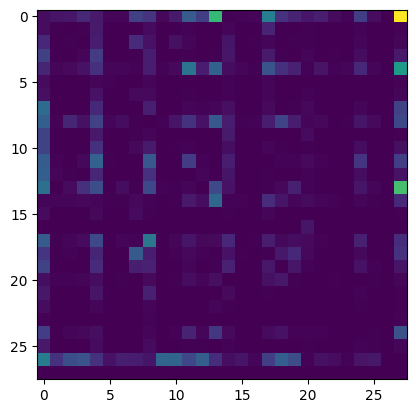

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(N)

But let's make it prettier.

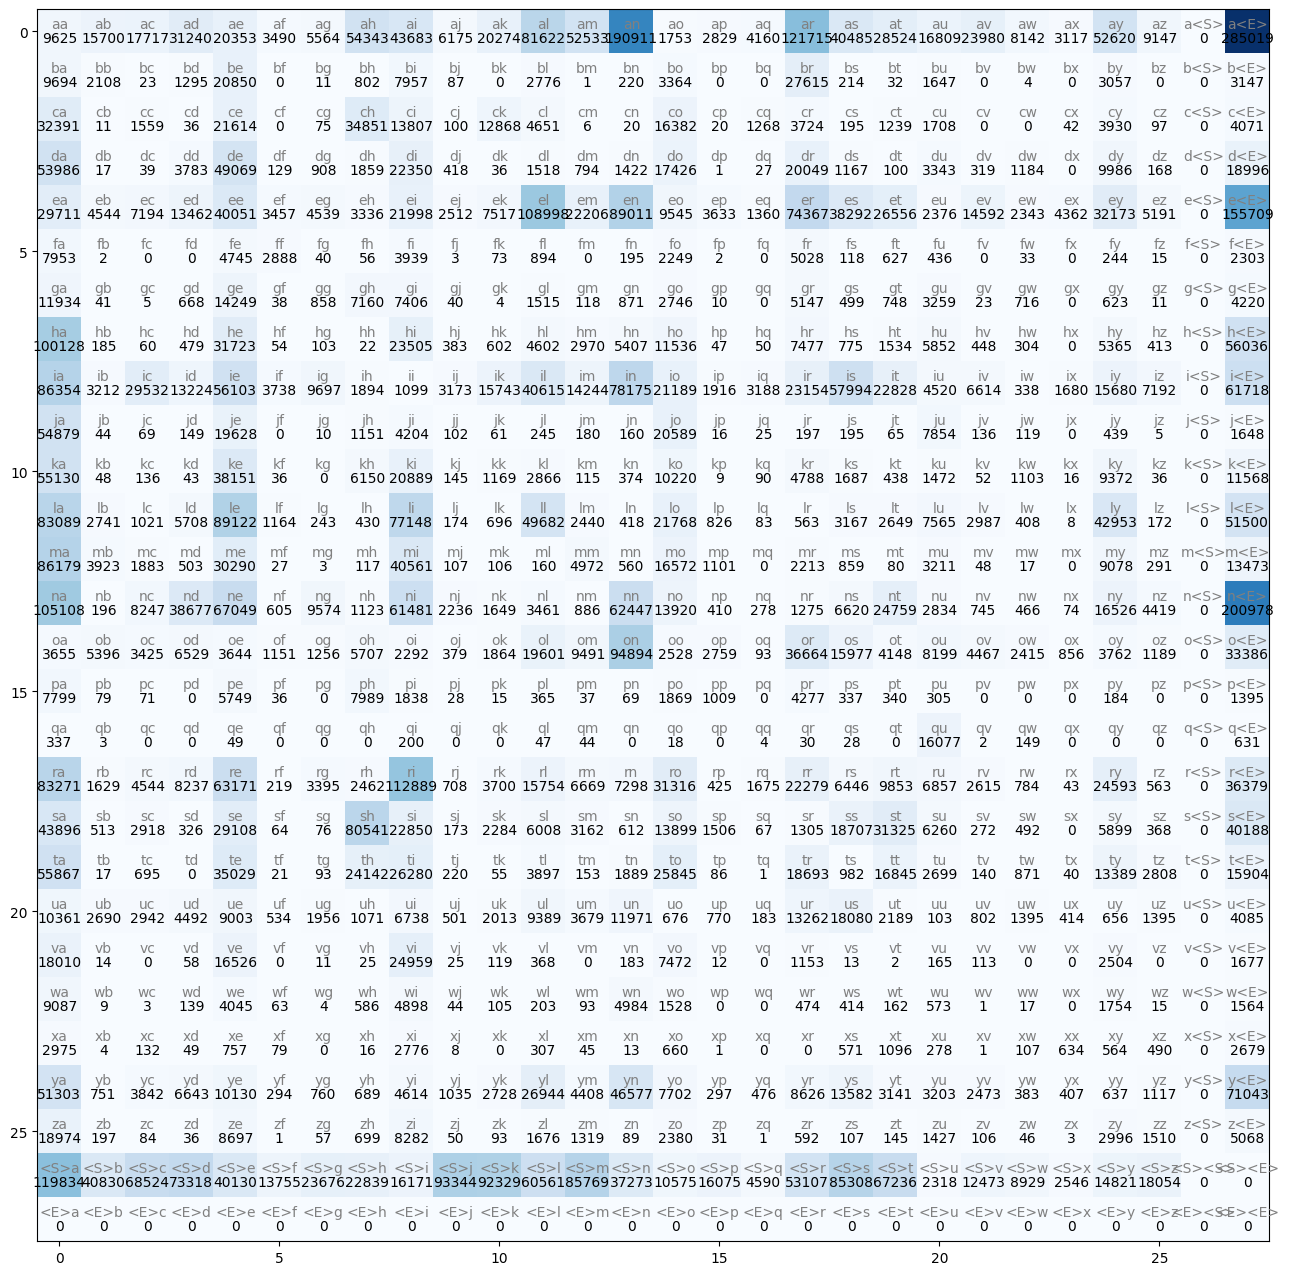

In [81]:
# iterate over all the items but reverse array
itos = {i:s for s,i in stoi.items()}

# Create a table for the bigram
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(28):
    for j in range(28):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, N[i,j].item(), ha='center',va='top')


The digram looks very ugly. But the basic idea is, you get lots of lines which are empty. 

# Removing starter characters
For some reason, we don't need <S> and <E>, we can just call it one special character ".". So let's do that

In [130]:
chars = sorted(list(set(''.join(words).lower())))
stoi = {s:i+1 for i, s in enumerate(chars)} # starts index at 1
stoi['.'] = 0 # make special character 0
itos = {i+1:s for s, i in stoi.items()}

In [133]:
for w in words:
    chs = ['.'] + list(w.lower()) + ['.']
    # treat a name as an iterator. walk through the word in two character sequences
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

KeyError: 0

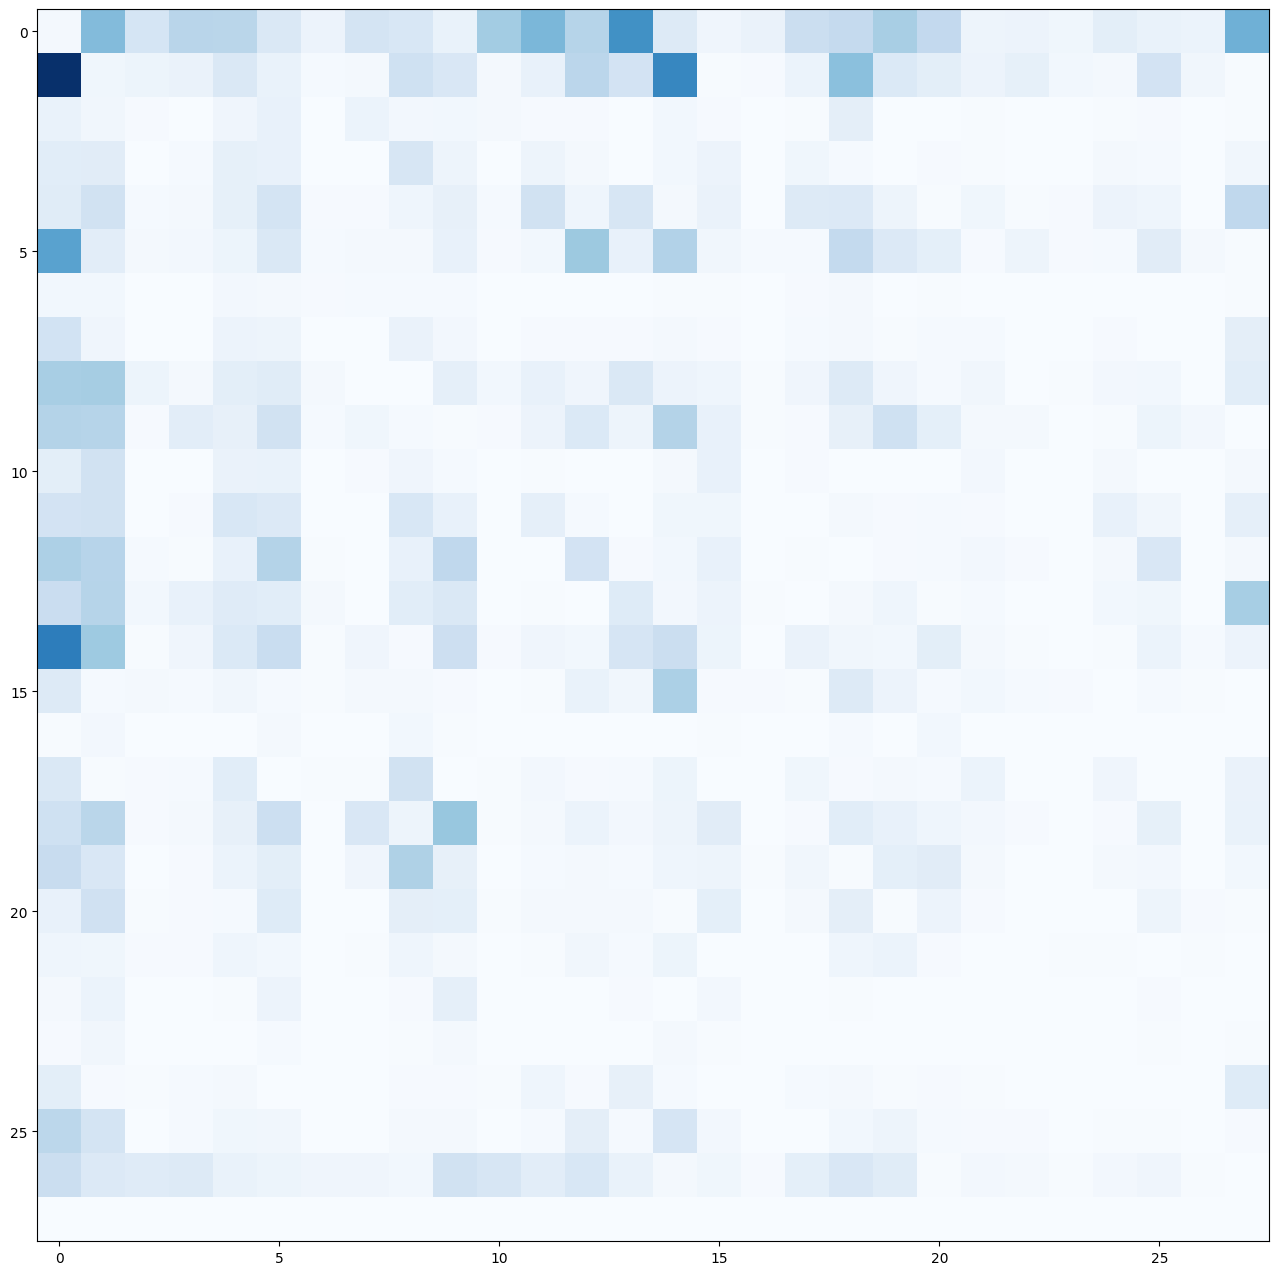

In [141]:
# iterate over all the items but reverse array
itos = {i+1:s for s,i in stoi.items()}

# Create a table for the bigram
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, N[i,j].item(), ha='center',va='top')


We will follow these probablities and counts and get a name by sampling that character

In [88]:
N[0, :]

tensor([  9625, 135534,  58547,  99764,  93671,  43620,  19319,  78019,  66522,
         22346, 113618, 173951, 113094, 276680,  39026,  13404,  20235, 126305,
         93592, 113832,  84045,  26298,  20615,  12046,  55166,  23968,  18054,
        285019], dtype=torch.int32)

In [90]:
N[0].shape

torch.Size([28])

N[0] is bascally just the start of the characters. What is the probability of a word starting with these characters. We can just sample from the row

Create a probability vector

In [92]:
p = N[0].float()

tensor([  9625., 135534.,  58547.,  99764.,  93671.,  43620.,  19319.,  78019.,
         66522.,  22346., 113618., 173951., 113094., 276680.,  39026.,  13404.,
         20235., 126305.,  93592., 113832.,  84045.,  26298.,  20615.,  12046.,
         55166.,  23968.,  18054., 285019.])

But we need to normalize these counts to create a probability distribution

In [94]:
p = p / p.sum()
p

tensor([0.0043, 0.0606, 0.0262, 0.0446, 0.0419, 0.0195, 0.0086, 0.0349, 0.0298,
        0.0100, 0.0508, 0.0778, 0.0506, 0.1237, 0.0175, 0.0060, 0.0090, 0.0565,
        0.0419, 0.0509, 0.0376, 0.0118, 0.0092, 0.0054, 0.0247, 0.0107, 0.0081,
        0.1275])

p is now probabilities.

In [95]:
p.sum() == 1

tensor(True)

Let's now sample from these distributions. This is deteriministic so we can get consistent results

In [134]:
g = torch.Generator().manual_seed(21474836477)
p = torch.rand(3, generator=g)
p = p / p.sum()
p

tensor([0.5443, 0.4421, 0.0137])

This is basically giving us 3 probabilities. So the first index has a 54% probability, then 44%.

Now, let's sample the torch tensor of probability distributions. We pass in generator to get deterministic results

In [135]:
torch.multinomial(p, num_samples=20, replacement=True, generator=g)

tensor([1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 2, 1, 2, 0, 1, 0, 0, 0, 1, 1])

These are the results. After samplying 20 times, we get index 0 many times, index 1 many times and index 2 little times

Now, instead of sampling the generator, we sample our probability distribution for the start of the word.

In [136]:
p = N[0].float()
p = p / p.sum()
torch.multinomial(p, num_samples=20, replacement=True, generator=g)

tensor([ 1, 10,  7,  3, 12, 20,  9, 27, 19,  8, 27,  1,  7,  1, 27, 12,  6,  1,
         2, 27])

So here's the basic idea. Sample the array. Then, take the probability distribution of the index of the resulting item and sample it.

In [174]:
g = torch.Generator().manual_seed(24141)

print(itos)
itos[0] = '.'
ix = 0
while True:
    p = N[ix].float()
    p = p / p.sum()
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    
    print(itos[ix])
    if ix == 0:
        break

{2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 1: '.', 0: '.'}
.
b
k
x
p
.


Yeah so the bigram model is kind of shit. It only knows the context before it, so the fact that some names are only 1 letter wouldn't be a problem for it

In [ ]:
import pandas as pd

splits = {'train': 'data/train-00000-of-00001-0e84cb2beba9ea7e.parquet', 'test': 'data/test-00000-of-00001-df4a3dda87fb136c.parquet'}
df = pd.read_parquet("hf://datasets/jbrazzy/baby_names/" + splits["train"])

In [16]:
import torch
g = torch.Generator().manual_seed(24141)
words = df['Names']
chars = sorted(list(set(''.join(words).lower())))
stoi = {s:i+1 for i, s in enumerate(chars)} # starts index at 1
itos = {i+1:s for s,i in stoi.items()}
itos[0] = '.'
stoi['.'] = 0

N = torch.zeros((28, 28), dtype=torch.int32)

for w in words:
    chs = ['.'] + list(w.lower()) + ['.']
    # treat a name as an iterator. walk through the word in two character sequences
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

for i in range(50):
    ix = 0
    out= []
    while True:
        p = N[ix].float()
        p = p/p.sum()
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

KeyError: 1

In [17]:
print(itos)
for i in range(50):
    ix = 0
    out= []
    while True:
        p = N[ix].float()
        p = p/p.sum()
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

{2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 0: '.'}
bkx.


KeyError: 1

Let's make efficiency improvements. 

Every row will have row of probabilities normalized to 1, indicating probability distribution of the next character

In [31]:
N = torch.zeros((28, 28), dtype=torch.int32)

for w in words:
    chs = ['.'] + list(w.lower()) + ['.']
    # treat a name as an iterator. walk through the word in two character sequences
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1
N

In [32]:
print(N)

tensor([[     0, 119834,  40830,  68524,  73318,  40130,  13755,  23676,  22839,
          16171,  93344,  92329,  60561,  85769,  37273,  10575,  16075,   4590,
          53107,  85308,  67236,   2318,  12473,   8929,   2546,  14821,  18054,
              0],
        [285019,   9625,  15700,  17717,  31240,  20353,   3490,   5564,  54343,
          43683,   6175,  20274,  81622,  52533, 190911,   1753,   2829,   4160,
         121715,  40485,  28524,  16809,  23980,   8142,   3117,  52620,   9147,
              0],
        [  3147,   9694,   2108,     23,   1295,  20850,      0,     11,    802,
           7957,     87,      0,   2776,      1,    220,   3364,      0,      0,
          27615,    214,     32,   1647,      0,      4,      0,   3057,      0,
              0],
        [  4071,  32391,     11,   1559,     36,  21614,      0,     75,  34851,
          13807,    100,  12868,   4651,      6,     20,  16382,     20,   1268,
           3724,    195,   1239,   1708,      0,      0

P will have all of the probabilities inside of it normalized to one. 

In [36]:
P = N.float()
P.sum()

tensor(7835242.)

P.sum sums up all of the counts of the matrix N

We want to divide all of the rows by their respective sums

In [42]:
P.sum(1)

tensor([1084385., 1151530.,   84904.,  154665.,  209094.,  729035.,   31843.,
          62909.,  260060.,  584814.,  112170.,  166103.,  448725.,  216334.,
         636043.,  275727.,   33791.,   17619.,  457774.,  312819.,  246661.,
         111350.,   73409.,   30765.,   14242.,  273805.,   54666.,       0.])

So remember, P is just the N 2x2 vector. So P has two dimensions, 0 and 1. We are saying sum against the y axis.
Note the shape of a simple sum

In [43]:
P.sum(1).shape

torch.Size([28])

We've removed the 2d vector from it. We can do keepdim to keep it

In [45]:
P.sum(0, keepdim=True)

tensor([[1084385., 1151530.,   84904.,  154665.,  209094.,  729035.,   31843.,
           62909.,  260060.,  584814.,  112170.,  166103.,  448725.,  216334.,
          636043.,  275727.,   33791.,   17619.,  457774.,  312819.,  246661.,
          111350.,   73409.,   30765.,   14242.,  273805.,   54666.,       0.]])

So these are sums among the columns
0 1 2 3 4 5

It's telling us for this column, what the sum is.

But we want the sum along the x axis. Because the way the bigrams work is the first x is the previous letter, and we want to get the next letter on that row.

In [49]:
P.sum(1, keepdim=True)

tensor([[1084385.],
        [1151530.],
        [  84904.],
        [ 154665.],
        [ 209094.],
        [ 729035.],
        [  31843.],
        [  62909.],
        [ 260060.],
        [ 584814.],
        [ 112170.],
        [ 166103.],
        [ 448725.],
        [ 216334.],
        [ 636043.],
        [ 275727.],
        [  33791.],
        [  17619.],
        [ 457774.],
        [ 312819.],
        [ 246661.],
        [ 111350.],
        [  73409.],
        [  30765.],
        [  14242.],
        [ 273805.],
        [  54666.],
        [      0.]])

Note: The sums of columns and arrays are the same due to the nature of bigrams.

In order to perform the operation P / P.sum(1,keepdim=True), we need to make sure these vectors are broadcastable. https://pytorch.org/docs/stable/notes/broadcasting.html

# 27, 27
# 27, 1

Since both have at least one dimension, and the dimensions sizes are equal or one of them is 1, we can perform this operation

In [54]:
P = P / P.sum(1,keepdim=True)
P

tensor([[0.0000e+00, 1.1051e-01, 3.7653e-02, 6.3192e-02, 6.7613e-02, 3.7007e-02,
         1.2685e-02, 2.1834e-02, 2.1062e-02, 1.4913e-02, 8.6080e-02, 8.5144e-02,
         5.5848e-02, 7.9095e-02, 3.4372e-02, 9.7521e-03, 1.4824e-02, 4.2328e-03,
         4.8974e-02, 7.8669e-02, 6.2004e-02, 2.1376e-03, 1.1502e-02, 8.2342e-03,
         2.3479e-03, 1.3668e-02, 1.6649e-02, 0.0000e+00],
        [2.4751e-01, 8.3584e-03, 1.3634e-02, 1.5386e-02, 2.7129e-02, 1.7675e-02,
         3.0308e-03, 4.8318e-03, 4.7192e-02, 3.7935e-02, 5.3624e-03, 1.7606e-02,
         7.0881e-02, 4.5620e-02, 1.6579e-01, 1.5223e-03, 2.4567e-03, 3.6126e-03,
         1.0570e-01, 3.5158e-02, 2.4771e-02, 1.4597e-02, 2.0824e-02, 7.0706e-03,
         2.7068e-03, 4.5696e-02, 7.9433e-03, 0.0000e+00],
        [3.7065e-02, 1.1418e-01, 2.4828e-02, 2.7089e-04, 1.5253e-02, 2.4557e-01,
         0.0000e+00, 1.2956e-04, 9.4460e-03, 9.3718e-02, 1.0247e-03, 0.0000e+00,
         3.2696e-02, 1.1778e-05, 2.5912e-03, 3.9621e-02, 0.0000e+00, 0.000

For the dimension that is 1. Tensorflow will broadcast the array, basically just copy it to match the other dimension

The sum of a row will be 1 because the rows are all normalized

In [57]:
P[0].sum()

tensor(1.)

Now, let's run the bigram generation again

In [62]:
g = torch.Generator().manual_seed(1231)
stoi = {s:i for i, s in enumerate(chars)} # starts index at 1
itos = {i+1:s for s,i in stoi.items()}
itos[0] = '.'
for i in range(50):
    ix = 0
    out= []
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

en.
an.
rmaya.
tha.
rymmanruizion.
eiandarianeleleeviaror.
marirustiniaryosaylenarll.
da.
lin.
aydoriclea.
haudake.
zka.
jonnzienahyavey.
jaa.
lia.
stay.
ghmien.
leroti.
m.
ad.
taminiaramkairah.
golstibay.
an.
hekete.
rkitovo.
liohe.
hiie.
ka.
s.
akaril.
alima.
ss.
ha.
flasiavona.
k.
kamrenno.
be.
taisisavo.
llieelvitailiveaiscy.
kadarin.
seyc.
bie.
jatrely.
domemmin.
tynna.
da.
atincanueacelilyalequron.
cha.
kin.
taurevicanta.
